# Setup

In [230]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from IPython.core.display import HTML

In [208]:
pd.options.display.float_format = '{:,.4f}'.format
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,12]

In [209]:
def getMetric(d, m):
    # return data.loc[(slice(None), slice(None), m), slice(None)]
    return data.xs(m, level='metric')

In [247]:
def perChainSeries(metric, window=1):
    d = getMetric(data, metric).loc[240:]
    fig, axes = plt.subplots(nrows=4, ncols=2)
    a = axes.reshape(-1)
    for i,c in enumerate(d.columns):
        ax = a[i]
        d[c].unstack().rolling(window=window).mean().plot(ax=ax, legend=False)
        ax.set_ylabel(c)

In [250]:
def perChainDensity(metric):
    d = getMetric(data, metric).loc[240:]
    fig, axes = plt.subplots(nrows=4, ncols=2)
    a = axes.reshape(-1)
    for i,c in enumerate(d.columns):
        ax = a[i]
        d[c].unstack().plot.kde(ax=ax, legend=False)
        ax.set_ylabel(c + "Density")

# Load Data

In [263]:
data = pd.read_pickle("data.pkl.gz", compression='gzip')

# Behavior Over Time

## Mean values accross chains per DA

In [211]:
metrics = data.index.get_level_values('metric').unique().tolist()

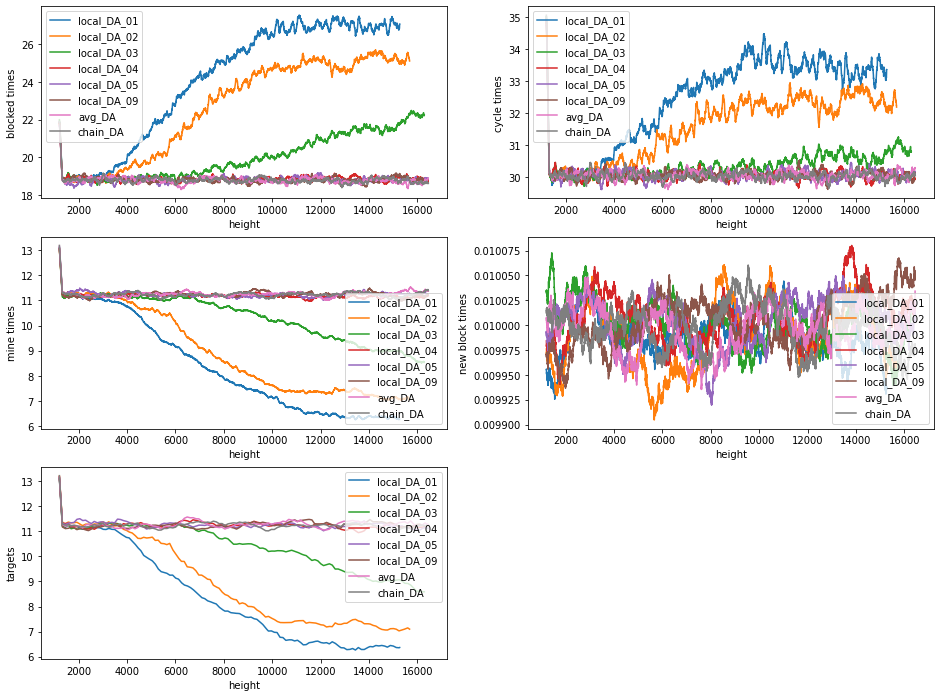

In [212]:
fig, axes = plt.subplots(nrows=3, ncols=2)
a = axes.reshape(-1)
for i,metric in enumerate(metrics):
    ax = a[i]
    ax.set_ylabel(metric)
    d = data.loc[(slice(None), slice(None), metric), slice(None)]
    e = d.mean(level=["height"]).rolling(window=1200).mean()
    e.plot(ax=ax, legend=True)
fig.delaxes(axes[2][1])

## Variance accross chains per DA

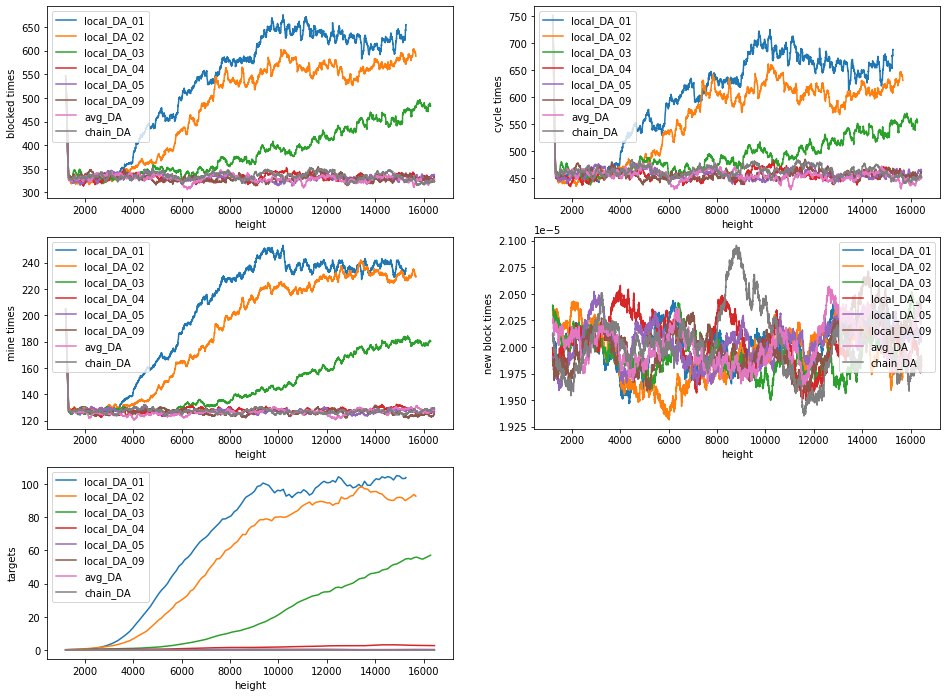

In [214]:
fig, axes = plt.subplots(nrows=3, ncols=2)
a = axes.reshape(-1)
for i,metric in enumerate(metrics):
    ax = a[i]
    ax.set_ylabel(metric)
    d = data.loc[(slice(None), slice(None), metric), slice(None)]
    e = d.var(level=["height"]).rolling(window=1200).mean()
    e.plot(ax=ax, legend=True)
fig.delaxes(axes[2][1])

Variance accross chains with an moving average over 120 blocks

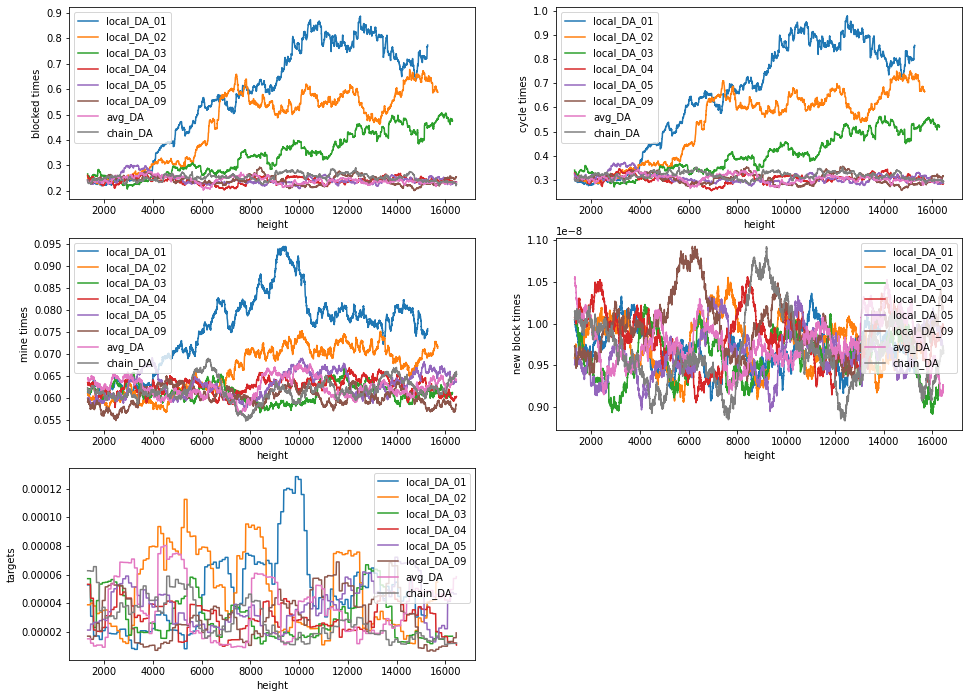

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=2)
a = axes.reshape(-1)
for i,metric in enumerate(metrics):
    ax = a[i]
    ax.set_ylabel(metric)
    d = data.loc[(slice(None), slice(None), metric), slice(None)].loc[120:]
    e = d.rolling(window=120).mean().var(level=["height"]).rolling(window=1200).mean()
    e.plot(ax=ax, legend=True)
fig.delaxes(axes[2][1])

## LocalDA on Devnet after Chain Graph Transition

The following shows the behavior of local DA on the Kadena Development network using the 12 nodes with in-node mining. 

The network does a transition from 10 to 20 chains at block height 50 (cut height 500). New chains start with a very low difficulty. Epoch windows size initially is 12 (block per chain). Starting with block height 120 the epoch window size is 120 blocks. 

This shows the targets over (almost) the full livetime of the network on a logarithmic scale (base 2). 

![image.png](images/localda-devnet-log.png)

The following shows the targets on a linear scale for just the tail (1000 minutes)

![image.png](images/localda-devnet-tail.png)

The algorithm manages to make the difficulties on all chains converge and maintains the difficulties between chains within a margin of about 10%.

# Blocked Times

In [184]:
getMetric(data, 'blocked times').loc[240:].describe()

,local_DA_01,local_DA_02,local_DA_03,local_DA_04,local_DA_05,local_DA_09,avg_DA,chain_DA
count,"300,624.0000","308,818.0000","320,999.0000","324,218.0000","324,051.0000","324,056.0000","324,136.0000","324,324.0000"
mean,24.0526,22.6449,20.0555,18.8368,18.8093,18.8170,18.7780,18.7799
std,24.7929,23.2858,20.5906,18.7385,18.7241,18.7048,18.6881,18.8251
min,0.0017,0.0013,0.0010,0.0012,0.0015,0.0016,0.0013,0.0017
25%,4.1316,3.5424,2.8081,2.4400,2.4143,2.4362,2.4716,2.3514
50%,17.7747,16.6868,14.9362,14.3845,14.3663,14.3604,14.3041,14.2478
75%,35.5594,33.9151,30.2346,28.8813,28.8439,28.8451,28.8059,28.7620
max,262.5251,231.8831,221.8565,174.4063,170.4155,190.6030,181.3147,179.7427


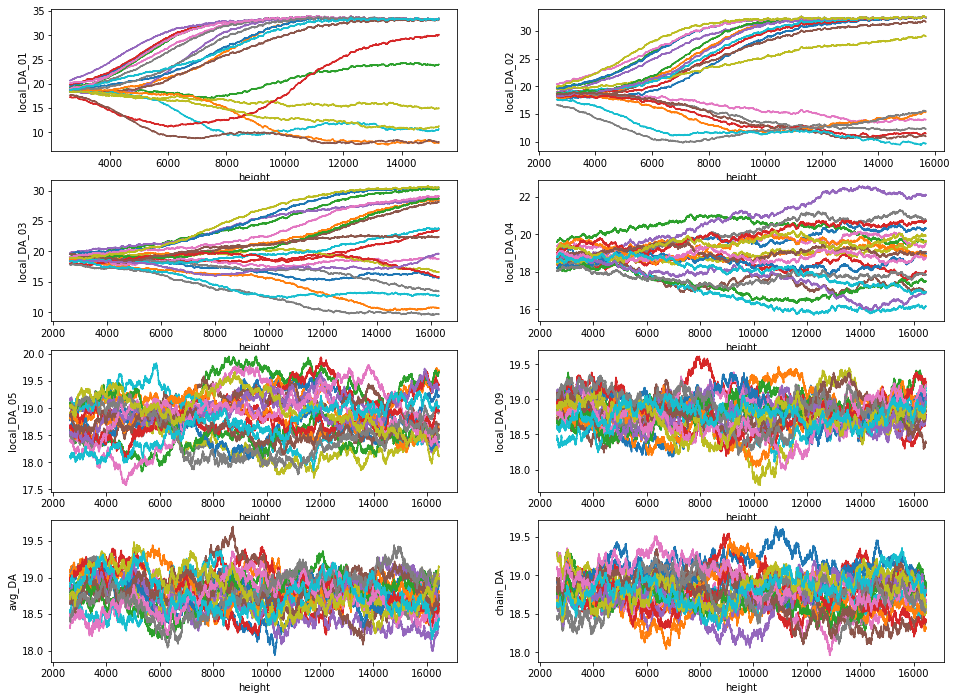

In [248]:
perChainSeries('blocked times', 2400)

An important property of DA is that no chain should be blocked more often than other. 

In [185]:
msg = "standard deviation of mean blocked times between chains"
d = pd.DataFrame({ msg: getMetric(data, 'blocked times').loc[240:].mean(level="chain").std() })
d

,standard deviation of mean blocked times between chains
local_DA_01,6.9137
local_DA_02,6.3521
local_DA_03,3.6906
local_DA_04,1.0270
local_DA_05,0.2175
local_DA_09,0.0826
avg_DA,0.0642
chain_DA,0.1139


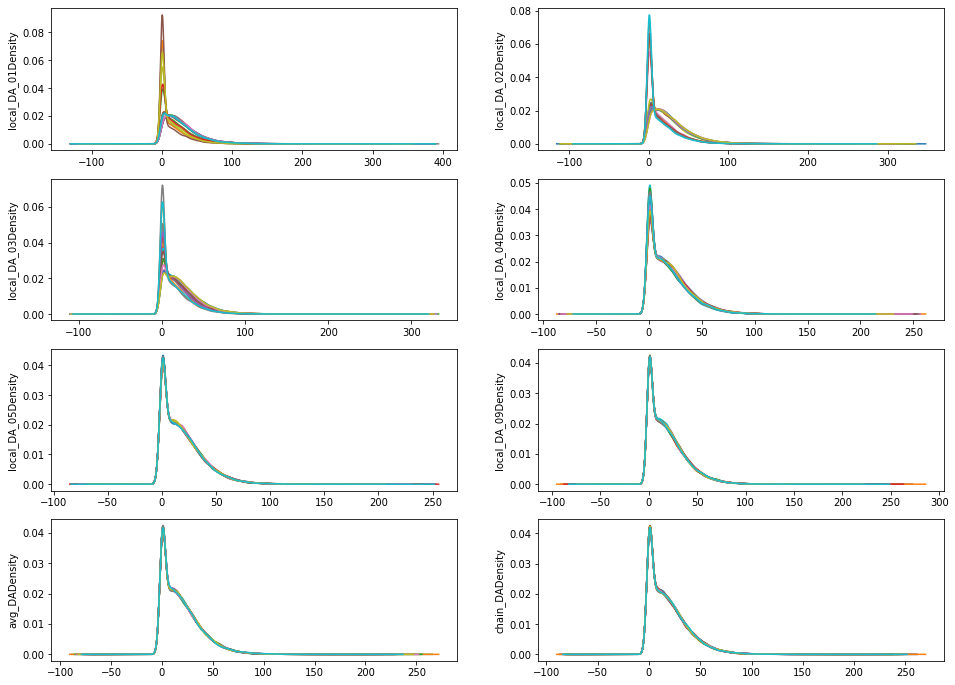

In [251]:
perChainDensity('blocked times')

In case that chains use different multipliers on their target during mining, we expect that initially chains with smaller multipliers are blocked for longer, because they resolve blocks faster. In those cases the use of `LocalDA` is expected to resolve the differences within a few epochs.

# Targets

In [186]:
getMetric(data, 'targets').loc[240:].describe()

,local_DA_01,local_DA_02,local_DA_03,local_DA_04,local_DA_05,local_DA_09,avg_DA,chain_DA
count,"300,624.0000","308,818.0000","320,999.0000","324,218.0000","324,051.0000","324,056.0000","324,136.0000","324,324.0000"
mean,8.3105,8.8889,10.3083,11.2382,11.2491,11.2394,11.2761,11.2352
std,8.1072,7.4263,4.6206,1.2932,0.6786,0.5909,0.3966,0.3525
min,0.0000,0.0000,0.0379,6.7864,8.9692,9.2949,10.3203,10.2502
25%,0.0501,0.6093,8.3649,10.4429,10.7794,10.8243,11.0216,11.0017
50%,8.2719,9.7428,10.9523,11.2032,11.2328,11.2205,11.2961,11.2466
75%,12.7454,14.2569,12.5393,12.0507,11.6927,11.6371,11.5201,11.4553
max,29.8243,26.6325,24.8130,15.5995,13.8434,13.2466,12.4007,12.3837


After a short initial stabilization time, targets are expected to have a constant mean over time with a relatively small variance per chain. There should be no obvious oscillations.

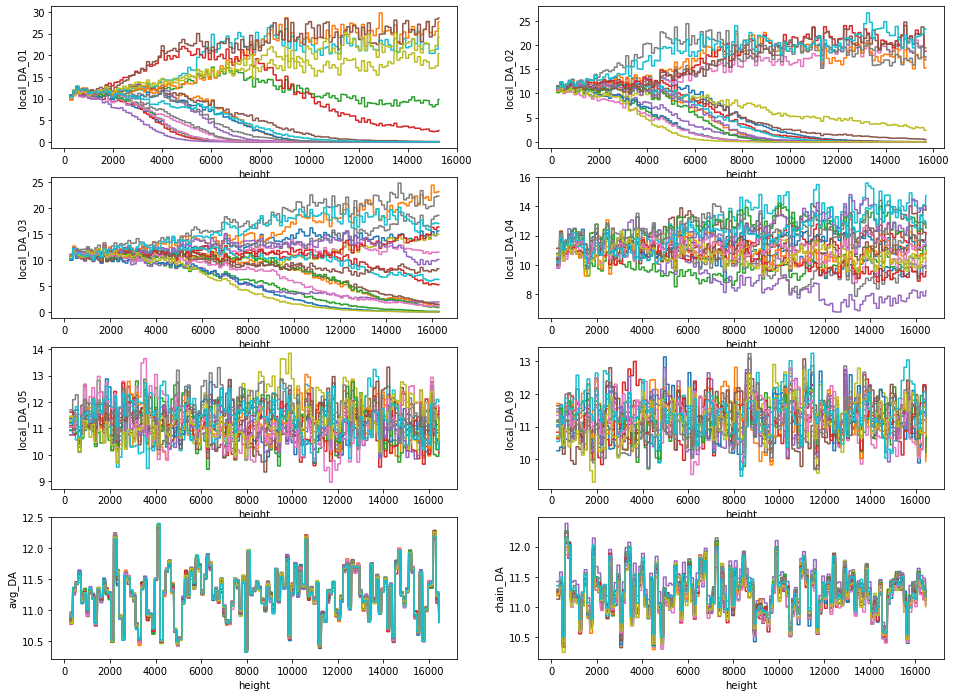

In [249]:
perChainSeries('targets')

Otherwise targets on all chains should have a similar mean with very little stanard deviation between chains (< 10%).

In [188]:
msg1 = "standard deviation of mean targets between chains"
msg2 = "standard deviation as percent of mean"
d = getMetric(data, 'targets').loc[240:].mean(level="chain")
pd.DataFrame({ msg1: d.std(), msg2: 100 * d.std() / d.mean()})

,standard deviation of mean targets between chains,standard deviation as percent of mean
local_DA_01,6.8868,82.8685
local_DA_02,6.3256,71.1628
local_DA_03,3.7179,36.0664
local_DA_04,1.0303,9.1681
local_DA_05,0.2454,2.1813
local_DA_09,0.1063,0.9454
avg_DA,0.0025,0.0225
chain_DA,0.0598,0.5319


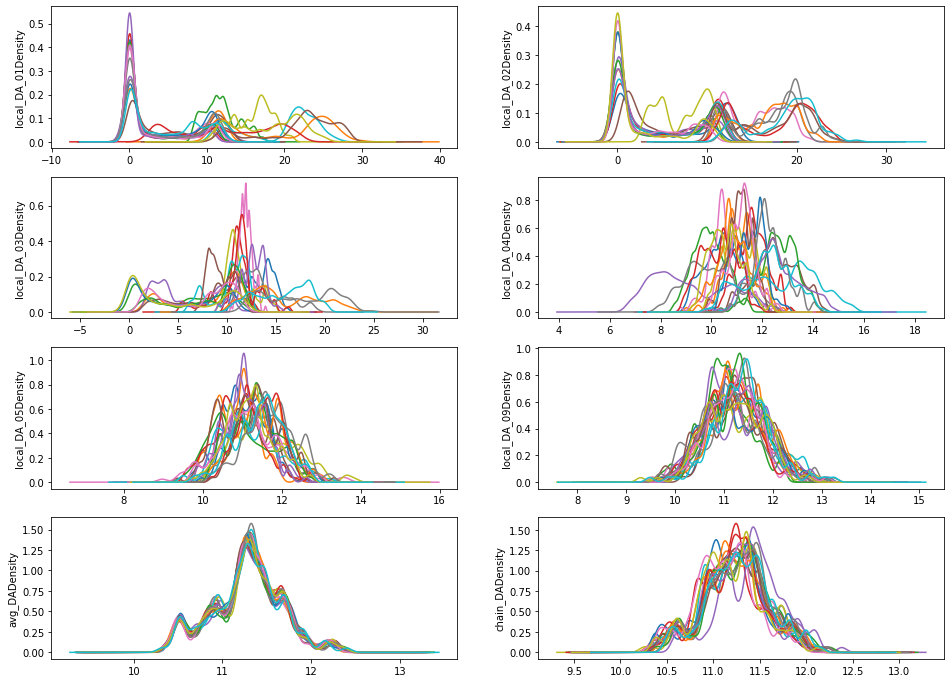

In [257]:
perChainDensity('targets')

The following plots relate targets for pairs of chains at similar block height. Postive linear relationship means that the targets are synchronized. A cloud shaped relation ship means that the DA algorithm doesn't syncrhonize chains, and chain targets are adjusted independently. A negative linear relationship means that the DA is struggling to balance the targets on different chains which most likely correlates with some chains being blocked too long and high orphan rates.

Generally, a more concentrated set signifies a more efficient DA.

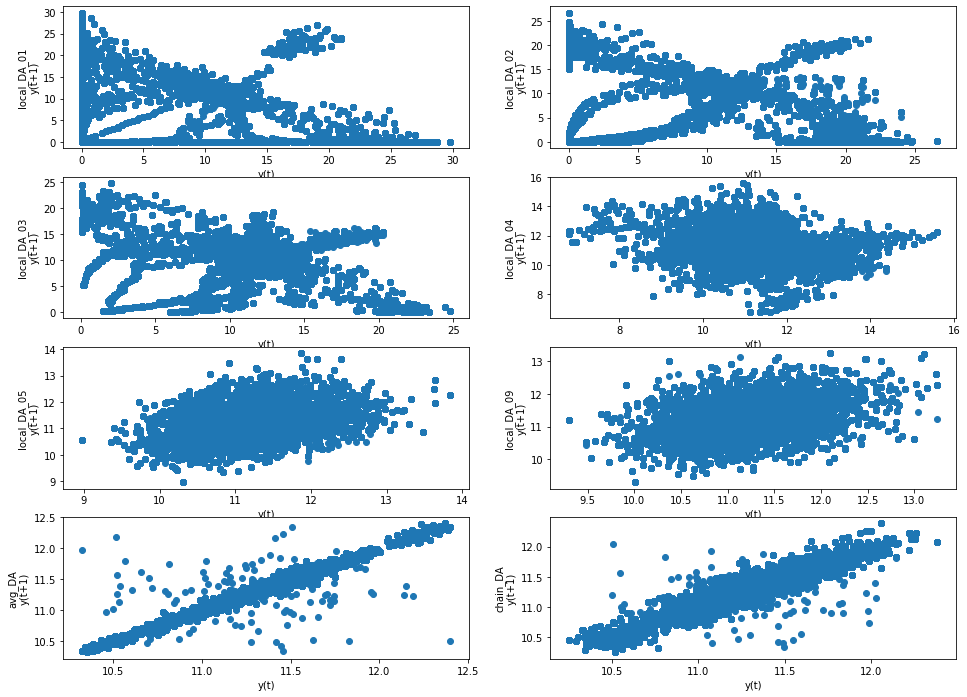

In [189]:
d = getMetric(data, 'targets').loc[240:]
fig, axes = plt.subplots(nrows=4, ncols=2)
a = axes.reshape(-1)
for i,c in enumerate(d.columns):
    ax = a[i]
    pdp.lag_plot(d[c], ax = ax)
    ax.set_xlabel("y(t)")
    ax.set_ylabel(c + "\ny(t+1)")

If per chain target multipliers and `LocalDA` are used in mining targets are expected to start closely together and plateau after a few epoches on a chain specific value value.

# Block Times

In [48]:
getMetric(data, 'cycle times').loc[240:].describe()

,local_DA_01,local_DA_02,local_DA_03,local_DA_04,local_DA_05,local_DA_09,avg_DA,chain_DA
count,"300,624.0000","308,818.0000","320,999.0000","324,218.0000","324,051.0000","324,056.0000","324,136.0000","324,324.0000"
mean,32.3723,31.5295,30.3210,30.0187,30.0529,30.0491,30.0385,30.0286
std,26.0597,24.8514,23.0087,21.8085,21.8647,21.8463,21.8186,21.9934
min,0.0143,0.0211,0.0160,0.0209,0.0190,0.0166,0.0210,0.0144
25%,13.0986,12.9136,12.9852,13.2157,13.1938,13.2378,13.3044,13.1164
50%,26.3984,25.9402,25.5298,25.9230,25.9159,25.8785,25.9095,25.8211
75%,44.7105,43.9122,42.1787,42.1289,42.1973,42.1296,42.0807,42.1562
max,271.6661,300.3813,229.6441,210.4981,202.5755,220.5786,218.8500,217.5157


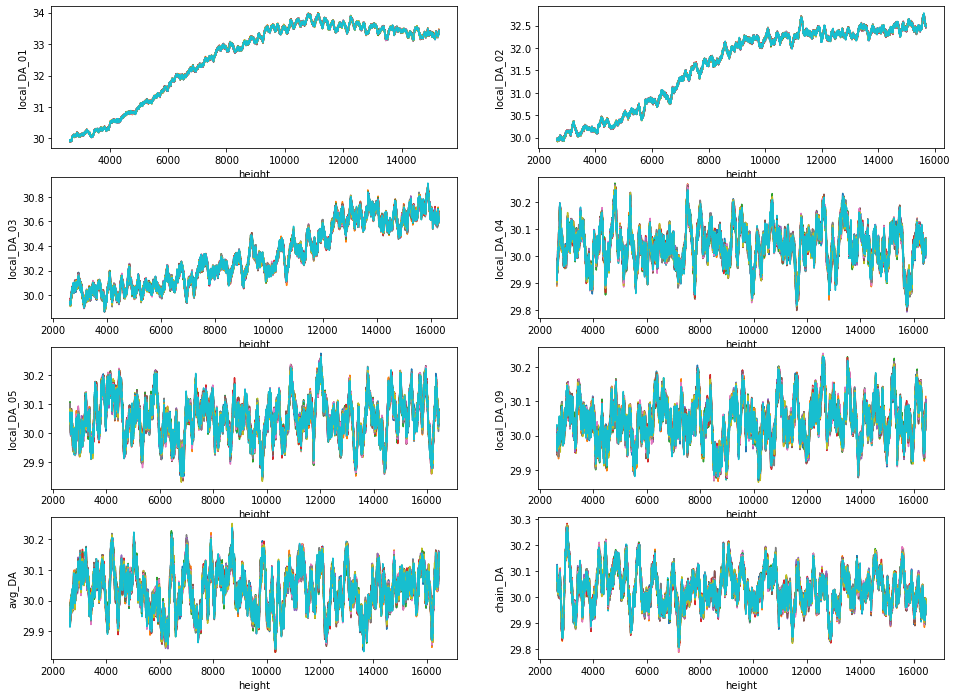

In [255]:
perChainSeries('cycle times', window=2400)

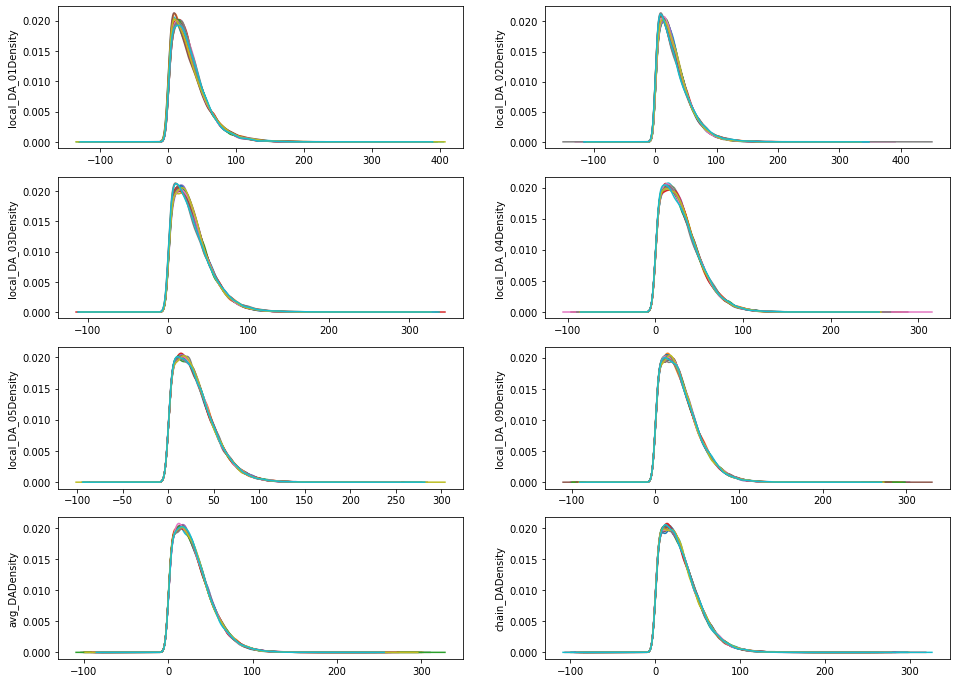

In [256]:
perChainDensity('cycle times')

# DA Details

metric,blocked times,cycle times,mine times,new block times,targets
count,"300,624.0000","300,624.0000","300,624.0000","300,624.0000","300,624.0000"
mean,24.0526,32.3723,8.3097,0.0100,8.3105
std,24.7929,26.0597,14.1922,0.0045,8.1072
min,0.0017,0.0143,0.0000,0.0004,0.0000
25%,4.1316,13.0986,0.0257,0.0067,0.0501
50%,17.7747,26.3984,2.2857,0.0093,8.2719
75%,35.5594,44.7105,10.6863,0.0125,12.7454
max,262.5251,271.6661,258.3342,0.0418,29.8243


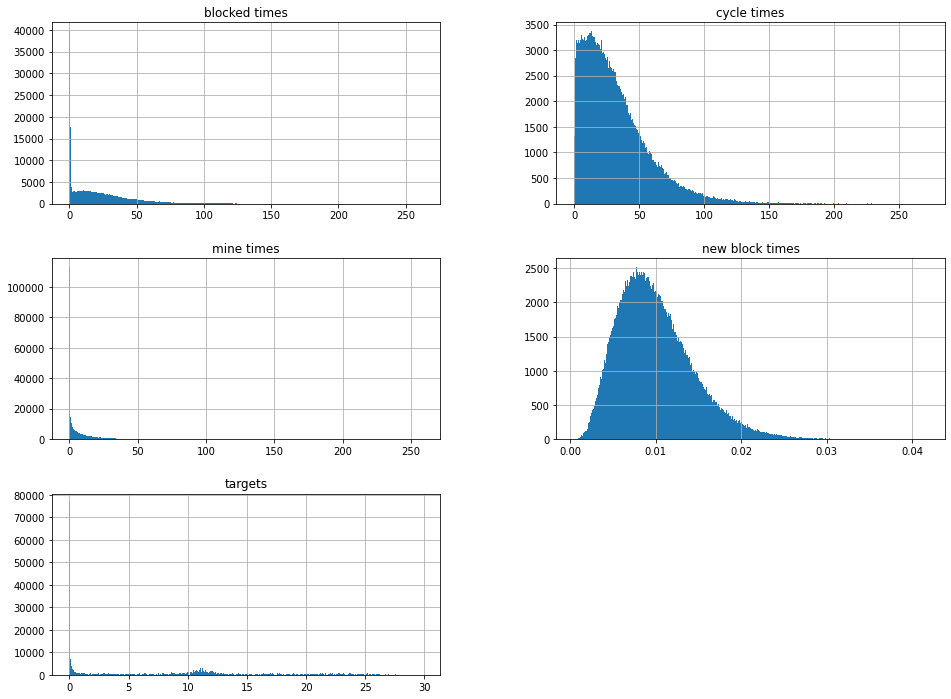

metric,blocked times,cycle times,mine times,new block times,targets
count,"308,818.0000","308,818.0000","308,818.0000","308,818.0000","308,818.0000"
mean,22.6449,31.5295,8.8746,0.0100,8.8889
std,23.2858,24.8514,13.7359,0.0045,7.4263
min,0.0013,0.0211,0.0000,0.0003,0.0000
25%,3.5424,12.9136,0.2264,0.0067,0.6093
50%,16.6868,25.9402,3.3430,0.0093,9.7428
75%,33.9151,43.9122,11.7901,0.0125,14.2569
max,231.8831,300.3813,230.7746,0.0475,26.6325


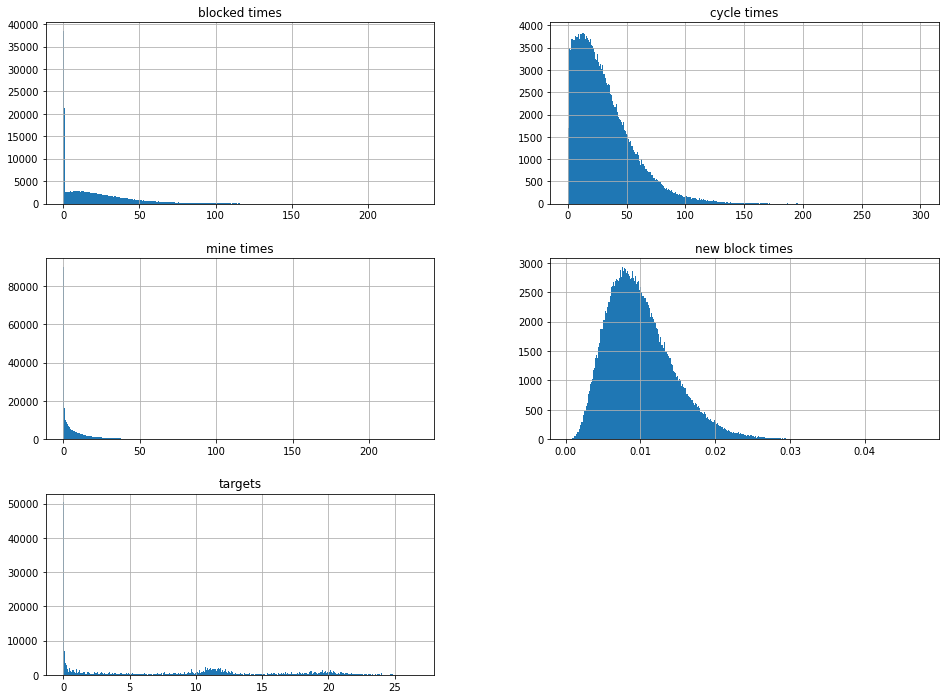

metric,blocked times,cycle times,mine times,new block times,targets
count,"320,999.0000","320,999.0000","320,999.0000","320,999.0000","320,999.0000"
mean,20.0555,30.3210,10.2555,0.0100,10.3083
std,20.5906,23.0087,12.1431,0.0045,4.6206
min,0.0010,0.0160,0.0000,0.0004,0.0379
25%,2.8081,12.9852,2.0854,0.0067,8.3649
50%,14.9362,25.5298,6.1502,0.0093,10.9523
75%,30.2346,42.1787,13.9900,0.0126,12.5393
max,221.8565,229.6441,222.8389,0.0440,24.8130


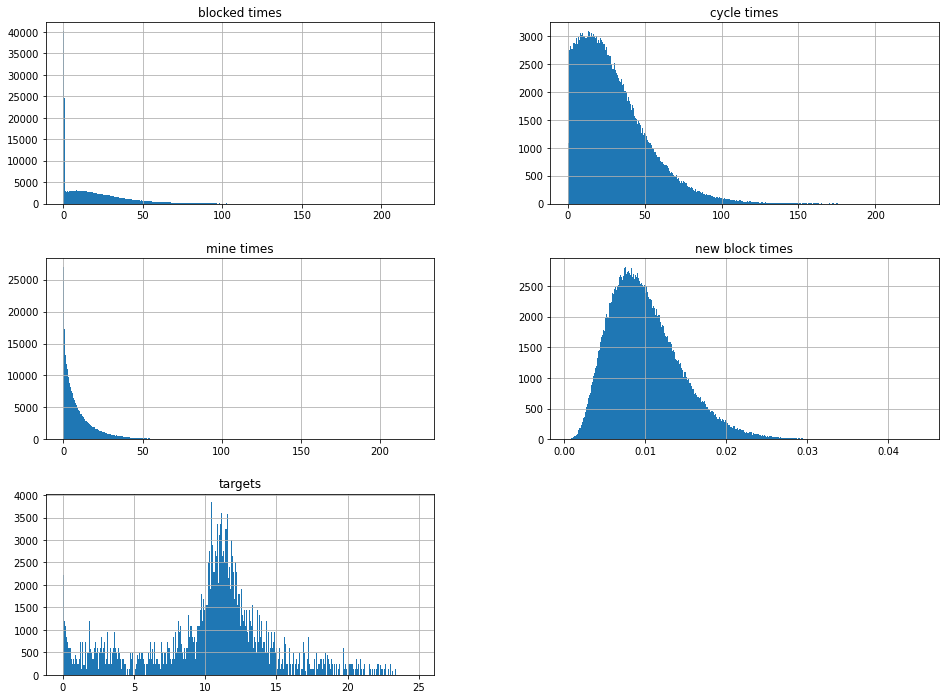

metric,blocked times,cycle times,mine times,new block times,targets
count,"324,218.0000","324,218.0000","324,218.0000","324,218.0000","324,218.0000"
mean,18.8368,30.0187,11.1719,0.0100,11.2382
std,18.7385,21.8085,11.2902,0.0045,1.2932
min,0.0012,0.0209,0.0000,0.0003,6.7864
25%,2.4400,13.2157,3.1774,0.0068,10.4429
50%,14.3845,25.9230,7.6809,0.0093,11.2032
75%,28.8813,42.1289,15.4527,0.0126,12.0507
max,174.4063,210.4981,148.8903,0.0439,15.5995


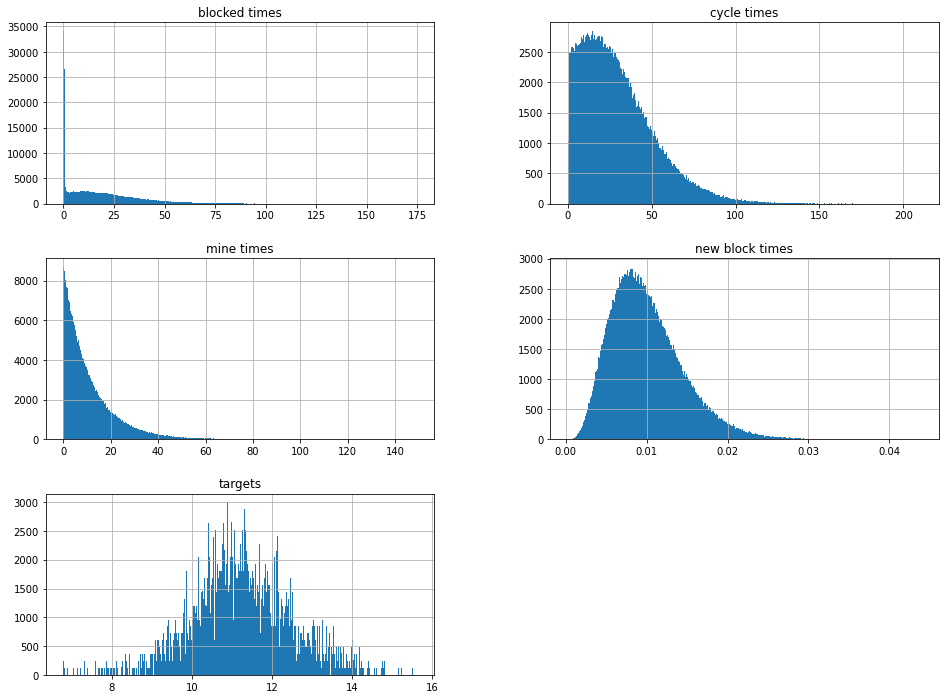

metric,blocked times,cycle times,mine times,new block times,targets
count,"324,051.0000","324,051.0000","324,051.0000","324,051.0000","324,051.0000"
mean,18.8093,30.0529,11.2336,0.0100,11.2491
std,18.7241,21.8647,11.2730,0.0045,0.6786
min,0.0015,0.0190,0.0001,0.0003,8.9692
25%,2.4143,13.1938,3.2218,0.0067,10.7794
50%,14.3663,25.9159,7.7553,0.0093,11.2328
75%,28.8439,42.1973,15.5527,0.0126,11.6927
max,170.4155,202.5755,168.0582,0.0437,13.8434


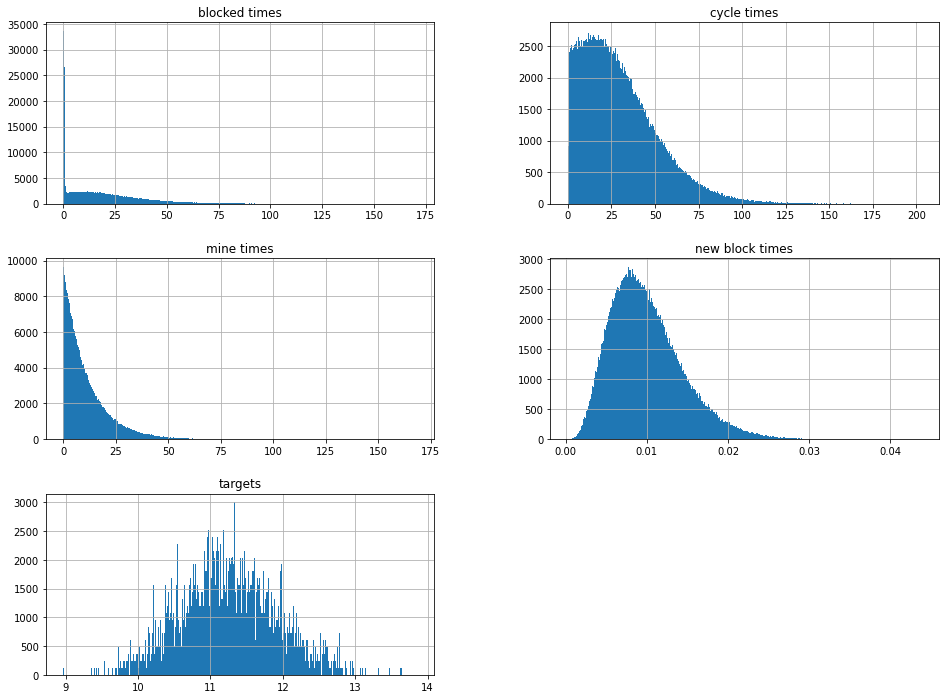

metric,blocked times,cycle times,mine times,new block times,targets
count,"324,056.0000","324,056.0000","324,056.0000","324,056.0000","324,056.0000"
mean,18.8170,30.0491,11.2220,0.0100,11.2394
std,18.7048,21.8463,11.2370,0.0045,0.5909
min,0.0016,0.0166,0.0000,0.0003,9.2949
25%,2.4362,13.2378,3.2273,0.0067,10.8243
50%,14.3604,25.8785,7.7794,0.0094,11.2205
75%,28.8451,42.1296,15.5264,0.0126,11.6371
max,190.6030,220.5786,158.8145,0.0475,13.2466


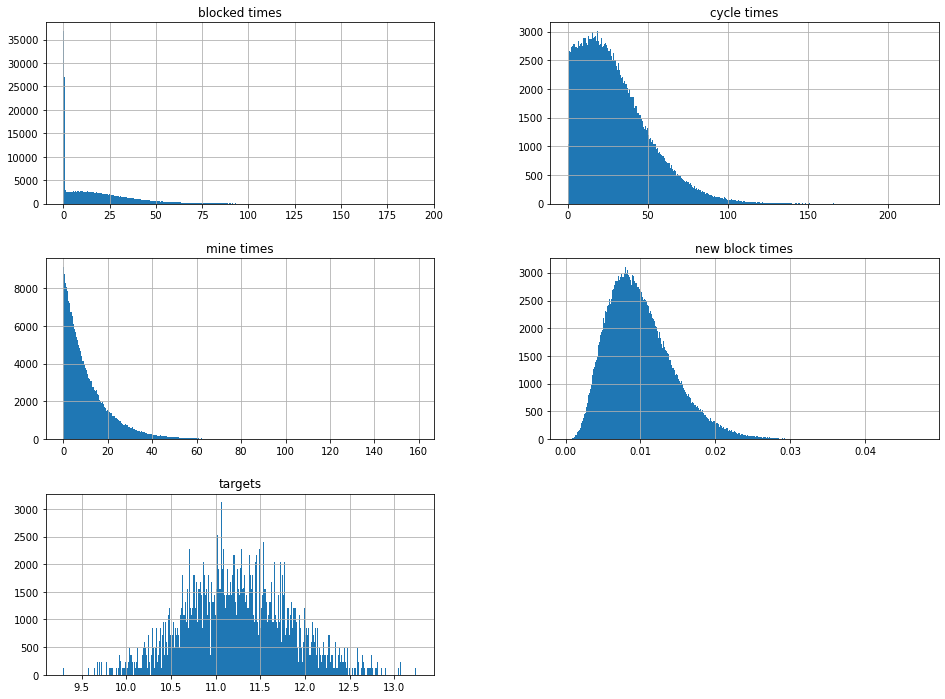

metric,blocked times,cycle times,mine times,new block times,targets
count,"324,136.0000","324,136.0000","324,136.0000","324,136.0000","324,136.0000"
mean,18.7780,30.0385,11.2505,0.0100,11.2761
std,18.6881,21.8186,11.2473,0.0045,0.3966
min,0.0013,0.0210,0.0001,0.0005,10.3203
25%,2.4716,13.3044,3.2366,0.0067,11.0216
50%,14.3041,25.9095,7.7868,0.0093,11.2961
75%,28.8059,42.0807,15.6220,0.0126,11.5201
max,181.3147,218.8500,155.2430,0.0479,12.4007


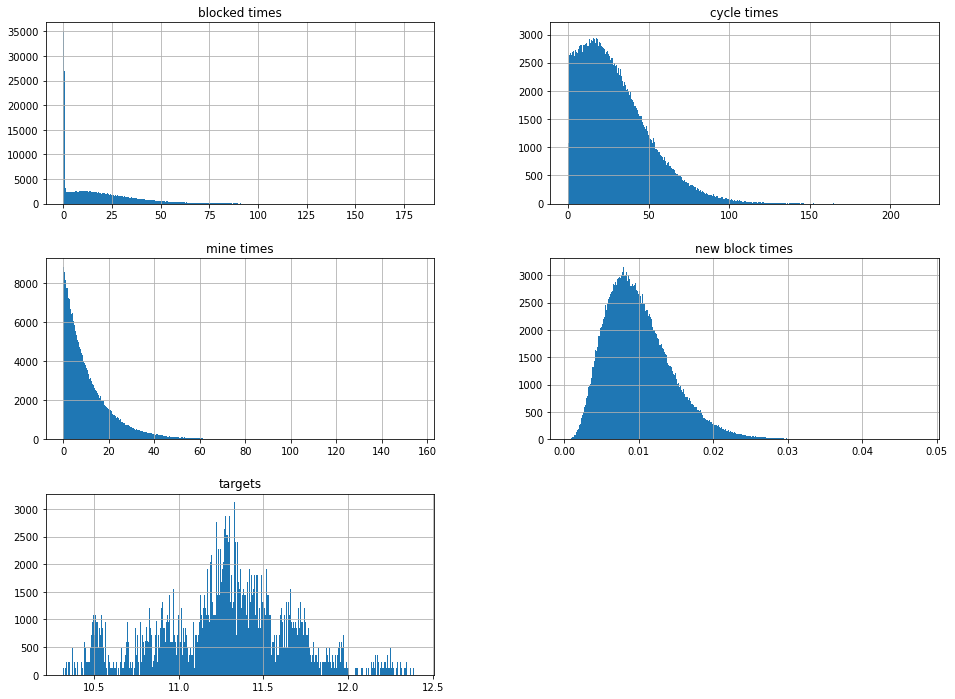

metric,blocked times,cycle times,mine times,new block times,targets
count,"324,324.0000","324,324.0000","324,324.0000","324,324.0000","324,324.0000"
mean,18.7799,30.0286,11.2387,0.0100,11.2352
std,18.8251,21.9934,11.2811,0.0045,0.3525
min,0.0017,0.0144,0.0000,0.0002,10.2502
25%,2.3514,13.1164,3.2059,0.0067,11.0017
50%,14.2478,25.8211,7.7619,0.0093,11.2466
75%,28.7620,42.1562,15.5633,0.0125,11.4553
max,179.7427,217.5157,151.7893,0.0479,12.3837


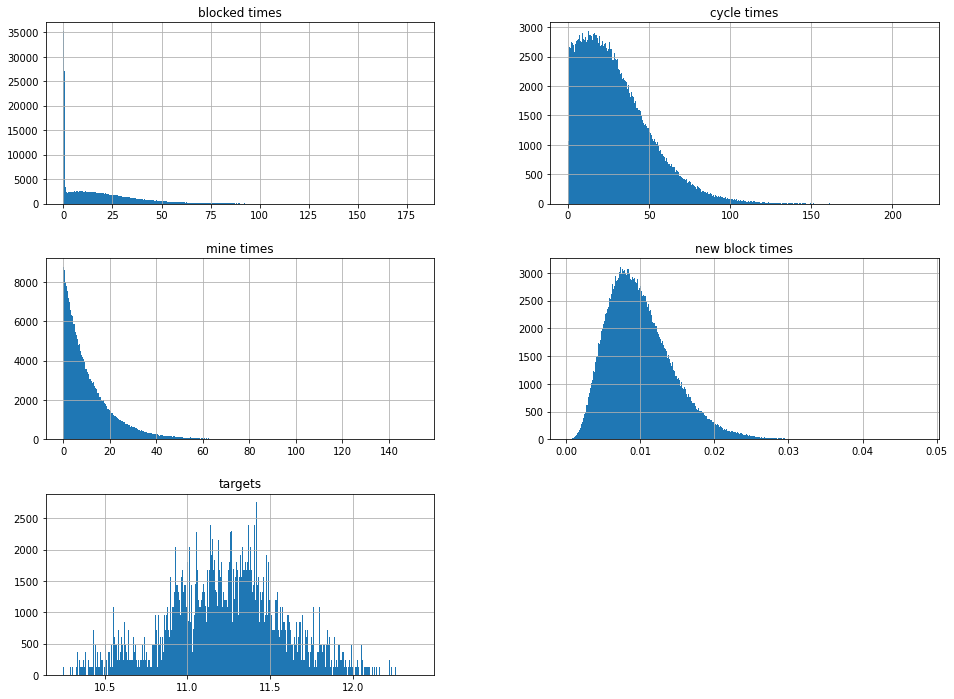

In [237]:
for da in data.columns:
    d = data[da].unstack().loc[240:]
    display(HTML("<h2>" + da + "</h2>"))
    display(d.describe())
    d.hist(bins=500)
    plt.show()